In [1]:
from aemulusnu_massfunction.utils import *
from aemulusnu_massfunction.massfunction import *

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

X = []
Y = []
idx = {}
cidx = 0
weird_boxes = ['Box63_1400', 'Box35_1400', 'Box_n50_38_1400', 'Box5_1400']
for box in cosmo_params:
    if(box in weird_boxes):
        continue
    X += [box]
    idx[box] = cidx
    cidx+=1
    Y += [[cosmo_params[box][key] for key in cosmo_params[box]]]
    
X = np.array(X)
Y = np.array(Y)

from aemulusnu_massfunction.utils import Standardizer

# Assuming Y is your input matrix with shape (n_samples, n_features)
# Create an instance of StandardScaler
scaler = Standardizer()

# Fit the scaler to the data
scaler.fit(Y)

# Standardize the data
Y = scaler.transform(Y)

print(len(X))

def find_most_central_datapoint_index(Y):
    centroid = np.mean(Y, axis=0)
    distances = np.linalg.norm(Y - centroid, axis=1)
    most_central_index = np.argmin(distances)
    return most_central_index
print('most central: ', X[find_most_central_datapoint_index(Y)])

def dist(a,b):
    return np.sqrt(np.sum(np.square(np.array(Y[b])-np.array(Y[a]))))

edges = [[dist(i,j) for i in range(len(X))] for j in range(len(X))]


import sys

def find_min_key(key, mst_set, n):
    min_key = sys.maxsize
    min_index = -1
    for i in range(n):
        if key[i] < min_key and not mst_set[i]:
            min_key = key[i]
            min_index = i
    return min_index

def prim_mst(edges, n):
    parent = [None] * n
    key = [sys.maxsize] * n
    mst_set = [False] * n

    key[0] = 0  # Start with the first node as the root
    parent[0] = -1  # Root has no parent

    for _ in range(n - 1):
        u = find_min_key(key, mst_set, n)
        mst_set[u] = True

        for v in range(n):
            if edges[u][v] > 0 and not mst_set[v] and edges[u][v] < key[v]:
                key[v] = edges[u][v]
                parent[v] = u

    mst = [[0] * n for _ in range(n)]
    for i in range(1, n):
        mst[i][parent[i]] = edges[i][parent[i]]
        mst[parent[i]][i] = edges[parent[i]][i]

    return mst

n = len(edges)

mst = prim_mst(edges, n)

from collections import deque

def bfs_traversal(mst, start):
    tot = 0
    n = len(mst)
    visited = [False] * n
    parent = [None] * n

    queue = deque()
    queue.append(start)
    visited[start] = True

    while queue:
        node = queue.popleft()
        print("%-10s"%(X[node]), end='\t ')
        if parent[node] is not None:
            prev = parent[node]
            dist = np.sqrt(np.sum(np.square(np.array(Y[idx[X[node]]])- np.array(Y[idx[X[prev]]]))))
            tot += dist
            curr_params_fname = "/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(X[node], 1.0) 
            curr_params = None
            with open(curr_params_fname, "rb") as f:
                curr_params = pickle.load(f)
            prev_params_fname = "/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(X[parent[node]], 1.0) 
            prev_params = None
            with open(prev_params_fname, "rb") as f:
                prev_params = pickle.load(f)
            print("Prev: %-10s\t distance:%.2f"%(X[parent[node]], dist))
            for key in prev_params:
                if(np.abs(prev_params[key]-curr_params[key])/curr_params[key] > .1):
                    print('\t%s\n\t\tPrev:%.2f\n\t\tCurr:%.2f'%(key,prev_params[key], curr_params[key]))
        print()

        for neighbor in range(n):
            if mst[node][neighbor] > 0 and not visited[neighbor]:
                queue.append(neighbor)
                visited[neighbor] = True
                parent[neighbor] = node
    assert(all(visited))
    print(tot)

start_node = idx['Box_n50_0_1400'] # Starting node for traversal

bfs_traversal(mst, start_node)


146
most central:  Box_n50_0_1400
Box_n50_0_1400	 
Box_n50_14_1400	 Prev: Box_n50_0_1400	 distance:1.02
	e
		Prev:0.30
		Curr:0.34

Box_n50_21_1400	 Prev: Box_n50_0_1400	 distance:1.18
	e
		Prev:0.30
		Curr:0.24

Box_n50_33_1400	 Prev: Box_n50_0_1400	 distance:1.04
	e
		Prev:0.30
		Curr:0.34

Box_n50_35_1400	 Prev: Box_n50_0_1400	 distance:1.00
	e
		Prev:0.30
		Curr:0.34

Box_n50_44_1400	 Prev: Box_n50_0_1400	 distance:1.12
	e
		Prev:0.30
		Curr:0.37

Box3_1400 	 Prev: Box_n50_14_1400	 distance:1.52

Box73_1400	 Prev: Box_n50_21_1400	 distance:1.67
	e
		Prev:0.24
		Curr:0.31

Box_n50_36_1400	 Prev: Box_n50_21_1400	 distance:0.81
	e
		Prev:0.24
		Curr:0.31

Box_n50_19_1400	 Prev: Box_n50_33_1400	 distance:1.06
	e
		Prev:0.34
		Curr:0.40

Box_n50_37_1400	 Prev: Box_n50_33_1400	 distance:0.77

Box_n50_42_1400	 Prev: Box_n50_33_1400	 distance:1.22
	e
		Prev:0.34
		Curr:0.44
	f
		Prev:1.64
		Curr:1.45

Box_n50_46_1400	 Prev: Box_n50_33_1400	 distance:1.20
	e
		Prev:0.34
		Curr:0.41

Box_n50

Box54_1400	 Prev: Box49_1400	 distance:2.42

Box59_1400	 Prev: Box49_1400	 distance:1.93

Box46_1400	 Prev: Box23_1400	 distance:2.23
	e
		Prev:0.27
		Curr:0.36

Box_n50_23_1400	 Prev: Box23_1400	 distance:1.75
	e
		Prev:0.27
		Curr:0.31

Box12_1400	 Prev: Box85_1400	 distance:2.40
	d
		Prev:0.37
		Curr:0.31
	e
		Prev:0.22
		Curr:0.07

Box86_1400	 Prev: Box71_1400	 distance:1.72
	e
		Prev:0.45
		Curr:0.37

Box31_1400	 Prev: Box78_1400	 distance:2.14
	e
		Prev:0.35
		Curr:0.27

Box65_1400	 Prev: Box78_1400	 distance:1.40
	e
		Prev:0.35
		Curr:0.47

Box43_1400	 Prev: Box80_1400	 distance:1.66
	e
		Prev:0.28
		Curr:0.41

Box22_1400	 Prev: Box54_1400	 distance:2.60

Box58_1400	 Prev: Box46_1400	 distance:2.00
	e
		Prev:0.36
		Curr:0.24

Box81_1400	 Prev: Box46_1400	 distance:2.42

Box50_1400	 Prev: Box86_1400	 distance:1.86

Box84_1400	 Prev: Box50_1400	 distance:1.34

223.913056685138


In [2]:
a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f) 
a_list_f.close()

###TEMP
# a_list = [a_list[0], a_list[1]]
#######
print('alist', a_list)

alist [1.0, 0.953321, 0.866399, 0.787402, 0.715608, 0.65036, 0.620002, 0.591061, 0.563471, 0.537169, 0.512095, 0.488191, 0.403224, 0.366459]


Text(0.5, 0, 'a')

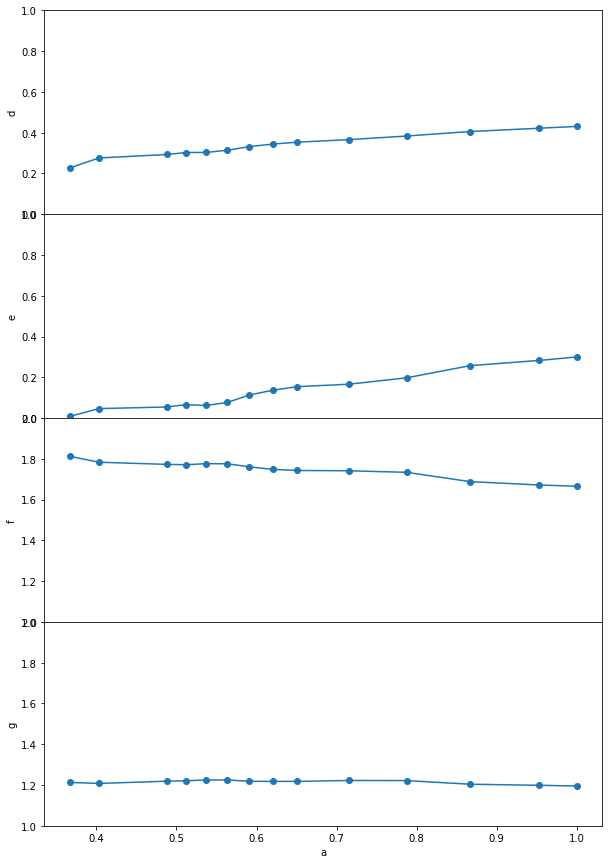

In [3]:
import matplotlib.pyplot as plt
box = 'Box_n50_0_1400'
# box = 'Box0_1400'
# box = 'Box78_1400'
# box = 'Box42_1400'
param_names = ['d','e','f','g']
ndim = len(param_names)


params = {'d':[], 'e':[], 'f':[], 'g':[]}
for a in a_list:
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a), "rb") as f:
        MLE_params = pickle.load(f)
    for key in MLE_params:
        params[key] += [MLE_params[key]]
        
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(10,15), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)

for i, param in enumerate(params):
    axs[i].scatter(a_list, params[param])
    axs[i].plot(a_list, params[param])

    axs[i].set_ylabel(param)
    axs[i].set_ylim([np.floor(min(params[param])),np.floor(min(params[param]))+1])
    
axs[-1].set_xlabel('a')